<ipython-input-19-6fad7675e9c5>:14: DtypeWarning: Columns (20) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('DATA.csv')


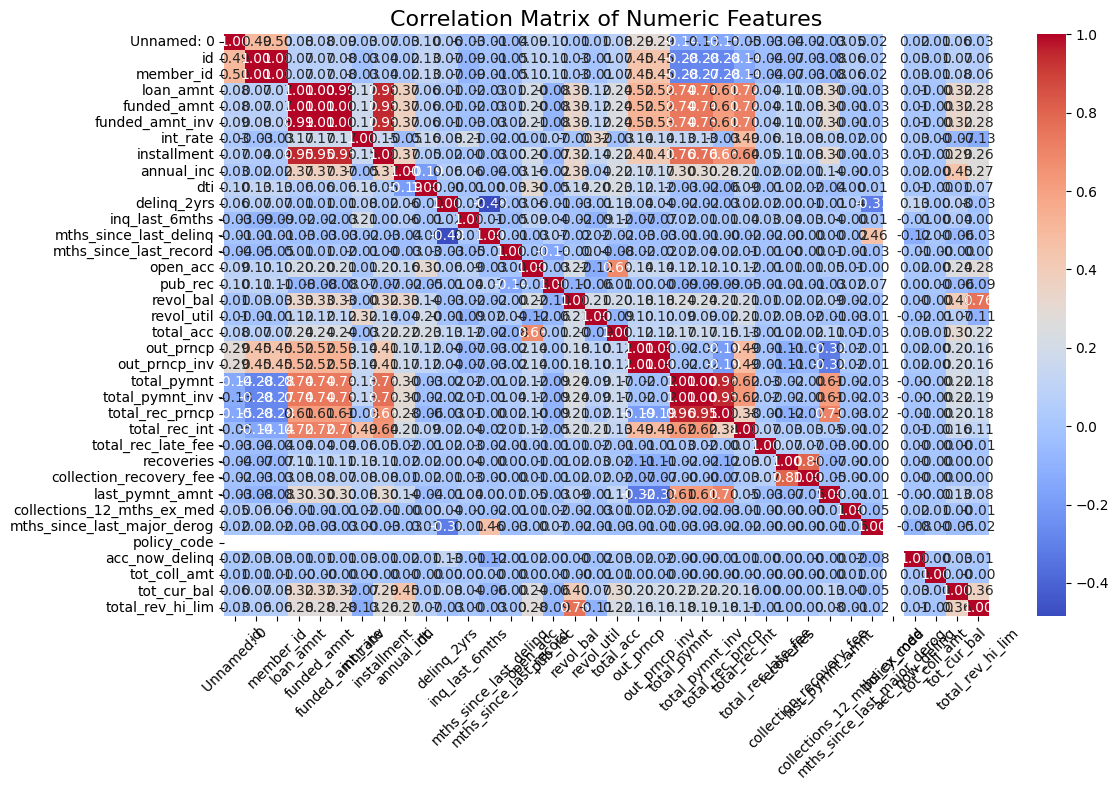

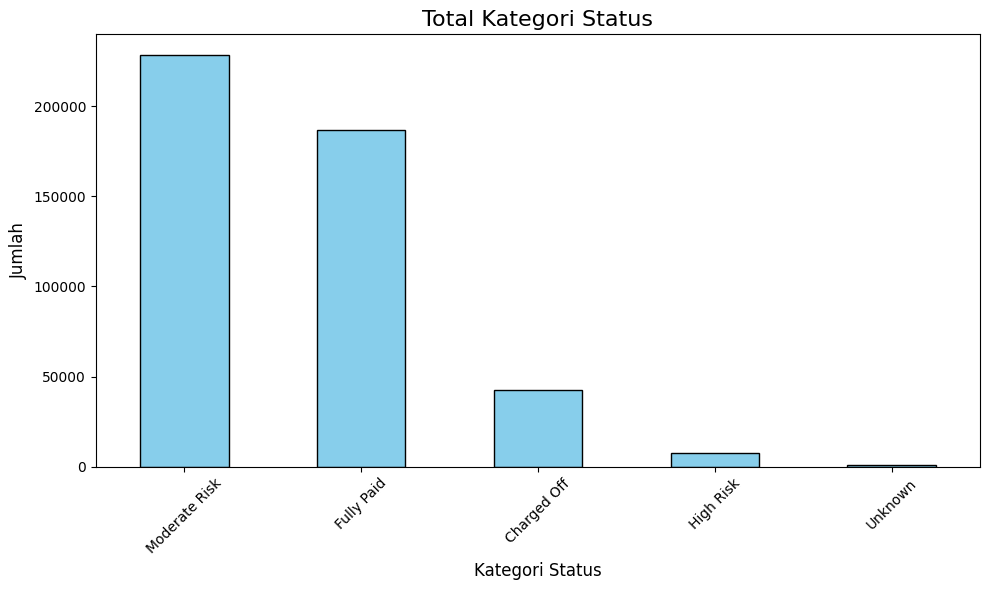

/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [31 92] are constant.
  warnings.warn("Features %s are constant." % constant_features_idx, UserWarning)
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:112: RuntimeWarning: invalid value encountered in divide
  f = msb / msw


Model: Logistic Regression
Accuracy: 0.9999892594382687
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8454
         1.0       1.00      1.00      1.00     37312
         2.0       1.00      1.00      1.00      1536
         3.0       1.00      1.00      1.00     45803

    accuracy                           1.00     93105
   macro avg       1.00      1.00      1.00     93105
weighted avg       1.00      1.00      1.00     93105



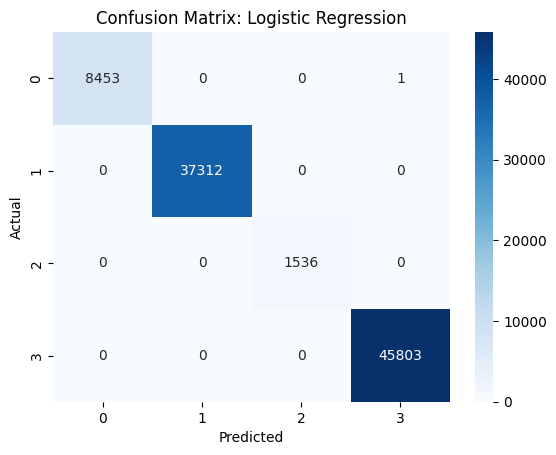

Model: Random Forest
Accuracy: 0.9999785188765372
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      8454
         1.0       1.00      1.00      1.00     37312
         2.0       1.00      1.00      1.00      1536
         3.0       1.00      1.00      1.00     45803

    accuracy                           1.00     93105
   macro avg       1.00      1.00      1.00     93105
weighted avg       1.00      1.00      1.00     93105



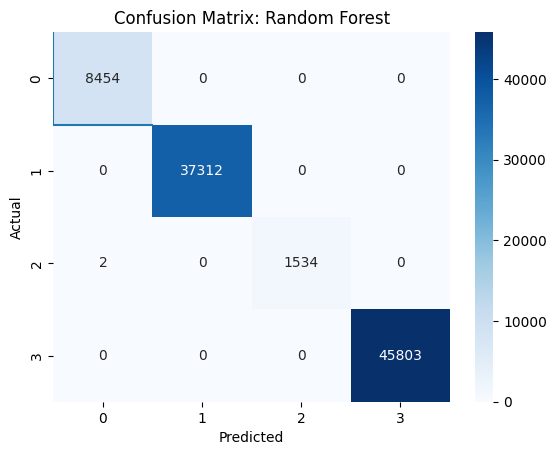

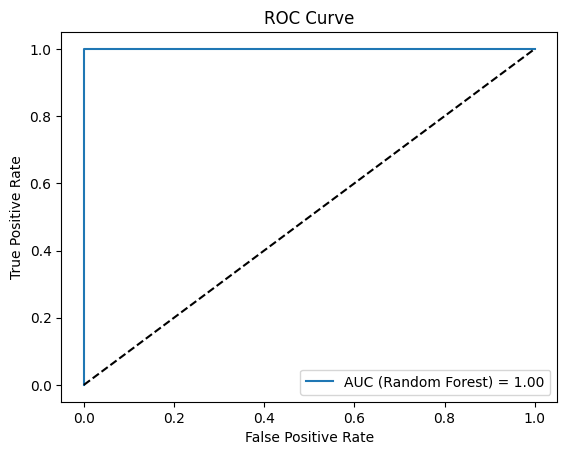

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sklearn.decomposition import PCA
from sklearn.feature_selection import SelectKBest, f_classif

# Data Understanding
data = pd.read_csv('DATA.csv')
data = data.dropna(axis=1, how='all')

# Exploratory Data Analysis (EDA)
numeric_cols = data.select_dtypes(include=['float64', 'int64']).columns
category_cols = data.select_dtypes(include=['object']).columns

# Fill missing numeric data with median
for col in numeric_cols:
    data[col] = data[col].fillna(data[col].median())
data['term'] = data['term'].str.replace(' months', '').astype(float)

# Fill missing categorical data with mode
for col in category_cols:
    data[col] = data[col].fillna(data[col].mode()[0])
data = data.drop('application_type', axis=1)



# Korelasi Data
plt.figure(figsize=(12, 8))
correlation_matrix = data[numeric_cols].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Numeric Features', fontsize=16)
plt.xticks(rotation=45)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

# Tentukan kolom status yang benar
status_col = 'loan_status' if 'loan_status' in data.columns else category_cols[0]

# Visualisasi distribusi status kategori
def categorize_status(value):
    fully_paid = ['Fully Paid', 'Does not meet the credit policy. Status:Fully Paid']
    charged_off = ['Charged Off', 'Does not meet the credit policy. Status: Charged Off']
    high_risk = ['Default', 'Late (31-120 days)']
    moderate_risk = ['In Grace Period', 'Late (16-30 days)', 'Current']
    if value in fully_paid:
        return 'Fully Paid'
    elif value in charged_off:
        return 'Charged Off'
    elif value in high_risk:
        return 'High Risk'
    elif value in moderate_risk:
        return 'Moderate Risk'
    return 'Unknown'

data['Status Category'] = data[status_col].apply(categorize_status)
plt.figure(figsize=(10, 6))
data['Status Category'].value_counts().plot(kind='bar', color='skyblue', edgecolor='black')
plt.title('Total Kategori Status', fontsize=16)
plt.xlabel('Kategori Status', fontsize=12)
plt.ylabel('Jumlah', fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Data Preparation
status_mapping = {
    'Charged Off': 0,
    'Fully Paid': 1,
    'High Risk': 2,
    'Moderate Risk': 3
}
data['Status Category Encoded'] = data['Status Category'].map(status_mapping)
# Encoding categorical variables (Limit categories to reduce memory usage)
for col in category_cols:
    # Skip 'application_type' if it's in category_cols since it was dropped
    if col == 'application_type':
        continue
    top_categories = data[col].value_counts().index[:10]  # Keep top 10 categories
    data[col] = data[col].apply(lambda x: x if x in top_categories else 'Other')

# Exclude 'Status Category' and 'Status Category Encoded' from get_dummies
data = pd.get_dummies(data, columns=[c for c in category_cols if c not in ['Status Category', 'Status Category Encoded', 'application_type']], drop_first=True)

# Feature selection
X = data.drop(columns=['Status Category', 'Status Category Encoded'])
y = data['Status Category Encoded']

#---CHANGE START---
# Drop rows with NaN in the target variable 'y'
X = X[~y.isna()]
y = y[~y.isna()]
#---CHANGE END---

# Reduce feature dimensions using SelectKBest
selector = SelectKBest(f_classif, k=80)  # Limit to top 50 features
X = selector.fit_transform(X, y)


# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Modelling & Evaluation
models = {'Logistic Regression': LogisticRegression(),
          'Random Forest': RandomForestClassifier()}

for name, model in models.items():
    print(f'Model: {name}')
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    print('Accuracy:', float(accuracy_score(y_test, y_pred)))
    print(classification_report(y_test, y_pred))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Confusion Matrix: {name}')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.show()

    if name == 'Random Forest':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=f'AUC (Random Forest) = {float(auc(fpr, tpr)):.2f}')

    if name == 'Logistic Regression':
        y_pred_proba = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_pred_proba, pos_label=1)
        plt.plot(fpr, tpr, label=f'AUC (Logistic Regression) = {float(auc(fpr, tpr)):.2f}')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()